# Theoretical Modelling Analysis
This script will be used to generate plots for my thesis, in particular I'll generate each of the plots i need for the theoretical modelling analysis. This should be versatile enough to work for the ZFOURGE observational (semi-empirical) models, and the pure theoretical models.

In [2]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

In [3]:
# Choose if you want to save the plots
save_figures = False
fig_size_params = (10, 6)

In [4]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

template_set_name = 'Brown'
agn_model_name = 'Type1AGN'

composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'

# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Drop the first col
#composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

In [5]:
# Check outputs
composite_fluxes

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.315776,-21.421279,-21.517432,-21.605757,-21.687435,-21.763396,-21.834388,...,-23.454779,-23.475153,-23.495151,-23.514788,-23.534076,-23.553028,-23.571654,-23.589966,-23.607974,-23.625689
1,Arp_256_N,0.0,-20.237172,-20.287567,-20.335726,-20.381839,-20.426074,-20.468576,-20.509478,-20.548894,...,-21.492481,-21.513877,-21.534859,-21.555444,-21.575645,-21.595478,-21.614955,-21.634088,-21.652890,-21.671372
2,Arp_256_S,0.0,-20.201401,-20.302567,-20.395105,-20.480372,-20.559427,-20.633115,-20.702117,-20.766996,...,-21.460665,-21.504041,-21.545751,-21.585917,-21.624651,-21.662050,-21.698203,-21.733192,-21.767088,-21.799958
3,CGCG_049-057,0.0,-17.401194,-17.657027,-17.863926,-18.037638,-18.187352,-18.318902,-18.436221,-18.542091,...,-19.901468,-19.939198,-19.975661,-20.010938,-20.045106,-20.078231,-20.110376,-20.141596,-20.171943,-20.201465
4,CGCG_436-030,0.0,-20.094718,-20.244207,-20.375583,-20.492764,-20.598521,-20.694885,-20.783389,-20.865219,...,-21.546386,-21.601016,-21.653028,-21.702663,-21.750127,-21.795603,-21.839250,-21.881211,-21.921609,-21.960559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,UGC_09618_N,3.9,37.371478,28.856104,28.103742,27.663585,27.351274,27.109020,26.911081,26.743724,...,27.953385,27.384060,27.012499,26.736186,26.516120,26.333229,26.176750,26.040009,25.918579,25.809374
124,UGC_09618,3.9,36.333443,28.487211,27.735031,27.294934,26.982653,26.740418,26.542491,26.375143,...,27.182581,26.759907,26.456444,26.219535,26.025174,25.860380,25.717334,25.590959,25.477772,25.375279
125,UGC_09618_S,3.9,34.982780,29.716301,28.967982,28.529176,28.217541,27.975693,27.778025,27.610862,...,27.645340,27.417662,27.229551,27.069268,26.929633,26.805926,26.694884,26.594152,26.501977,26.417019
126,UGC_12150,3.9,38.434321,29.718392,28.965994,28.525825,28.213508,27.971250,27.773309,27.605950,...,29.110326,28.410883,27.988959,27.685882,27.449206,27.255002,27.090322,26.947361,26.821052,26.707918


In [6]:
# Check which IRAC filters are available (whatever begins with IRAC)
irac_filters = [col for col in composite_fluxes.columns if col.startswith('IRAC')]
print(irac_filters)


['IRAC3.6_0', 'IRAC3.6_10', 'IRAC3.6_20', 'IRAC3.6_30', 'IRAC3.6_40', 'IRAC3.6_50', 'IRAC3.6_60', 'IRAC3.6_70', 'IRAC3.6_80', 'IRAC3.6_90', 'IRAC3.6_100', 'IRAC4.5_0', 'IRAC4.5_10', 'IRAC4.5_20', 'IRAC4.5_30', 'IRAC4.5_40', 'IRAC4.5_50', 'IRAC4.5_60', 'IRAC4.5_70', 'IRAC4.5_80', 'IRAC4.5_90', 'IRAC4.5_100', 'IRAC5.8_0', 'IRAC5.8_10', 'IRAC5.8_20', 'IRAC5.8_30', 'IRAC5.8_40', 'IRAC5.8_50', 'IRAC5.8_60', 'IRAC5.8_70', 'IRAC5.8_80', 'IRAC5.8_90', 'IRAC5.8_100', 'IRAC8.0_0', 'IRAC8.0_10', 'IRAC8.0_20', 'IRAC8.0_30', 'IRAC8.0_40', 'IRAC8.0_50', 'IRAC8.0_60', 'IRAC8.0_70', 'IRAC8.0_80', 'IRAC8.0_90', 'IRAC8.0_100']


In [7]:
# Check for each entry of a particular filter, how many variations of it there are i.e U_0, U_10
# Allow us to have a robust way of investigating the effects of the different alpha values automatically, without recoding the filter names/alpha values

# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


## UVJ
### Plot
The code below will generate a subplot for the UVJ diagrams of the theoretical models. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

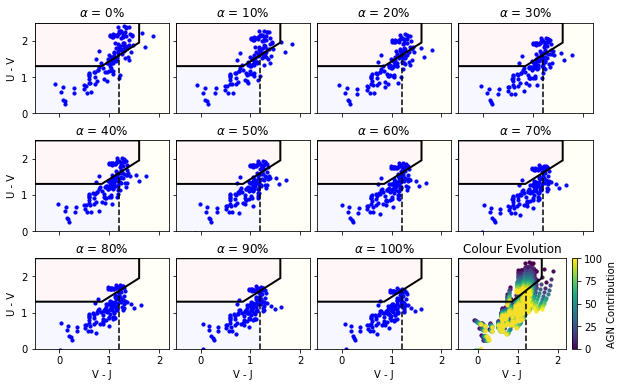

In [8]:
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))



fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[n]}']
    V_mag = composite_fluxes[f'V_{alpha_values[n]}']
    J_mag = composite_fluxes[f'J_{alpha_values[n]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    uv = uv[composite_fluxes['z'] == 0]
    vj = vj[composite_fluxes['z'] == 0]
    
    axs[n//4, n%4].scatter(vj, uv, c='blue', s=10)
    
    axs[n//4, n%4].set_xlim(-0.5, 2.2)
    axs[n//4, n%4].set_ylim(0, 2.5)
    
    # Plot AGN Contribution in the title 
    # alpha needs to be the alpha symbol
    #alpha_symbol = r'$\alpha$'
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Define paths for selections
    path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
    path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
    path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]
    
    # Add patches for selections
    axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))
    
    # Add vertical line
    axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)
    
    # Add axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("V - J")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U - V")

for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    uv = uv[composite_fluxes['z'] == 0]
    vj = vj[composite_fluxes['z'] == 0]
    
    # Plot scatter
    axs[2, 3].scatter(vj, uv, c=colours_theme[m], s=10)
    
    
# Add patches for selections
axs[2, 3].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs[2, 3].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs[2, 3].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs[2, 3].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs[2, 3].set_xlabel("V - J")

# AGN Colour Evolution title
axs[2, 3].set_title("Colour Evolution")



# Plot colorbar for AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Name the colorbar
cbar.set_label('AGN Contribution')

    
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_evolution_{agn_model_name}_{template_set_name}.png')

# Show the output
plt.show()


### Metrics
These will be used to analyze the results from the UVJ diagram above

## ugr
### Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

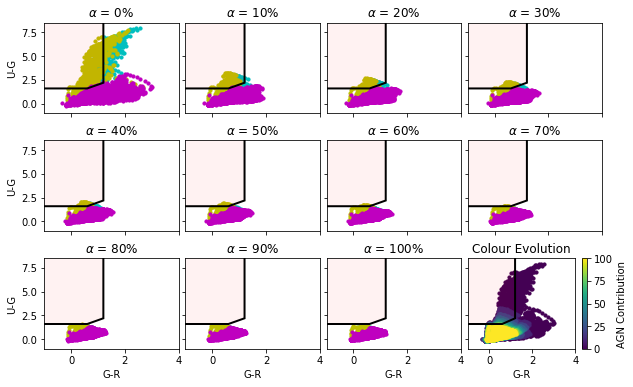

In [9]:

# ugr Diagram 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    # Get the u, g, and r magnitudes for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    # Set the AGN Contribution title 
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    plt.xlabel("")
    plt.ylabel("")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

      
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("G-R")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U-G")
    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
for m in range(len(alpha_values)):
    
    
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[m], 2))}'
    g_col_name = f'g_{int(round(alpha_values[m], 2))}'
    r_col_name = f'r_{int(round(alpha_values[m], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]
    
    # Scatter plots with color-coded redshift ranges
    axs[2, 3].scatter(gr_specific_alpha_colours, 
                               ug_specific_alpha_colours, 
                               c=colours_theme[m], s=10)


    
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
axs[2, 3].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

axs[2, 3].set_xlim(-1, 4)
axs[2, 3].set_ylim(-1, 8.5)

axs[2, 3].set_xlabel("G-R")



# Add a colorbar for the AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the colorbar label
cbar.set_label('AGN Contribution')

# add the final subplot labels
axs[2, 3].set_title("Colour Evolution")


# # Make all the plots touch

    
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_{template_set_name}.png')
    
# Plot
plt.show()
    

### Metrics

## IRAC 
### Plot


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

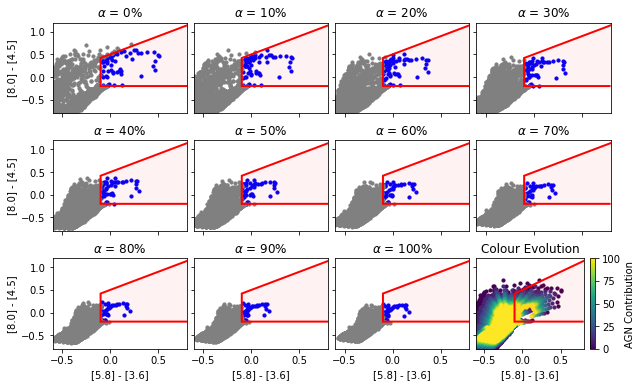

In [10]:
# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -0.6
ymin = -0.8



# setup 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    
    
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha
    axs[n//4, n%4].scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='blue', s=10)
    axs[n//4, n%4].scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # # Ensure we are only looking at the rest frame stuff
    # x = x[composite_fluxes['z'] == 0]
    # y = y[composite_fluxes['z'] == 0]
      # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    
    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    wedge_vertices = [
        (xmax, -0.2),
        (-0.1, -0.2),
        (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
        (((ymax-0.5)/0.8), ymax)
    ] 
    wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge')
    # Plot the polygon on the subplot
    axs[n//4, n%4].add_patch(wedge_polygon)
    
    
    # Set the AGN Contribution title
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("[8.0] - [4.5]")
    
    # Set the axis limits
    axs[n//4, n%4].set_xlim(xmin, xmax)
    axs[n//4, n%4].set_ylim(ymin, ymax)
    
# We want an AGN evolution plot for
for m in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[m]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[m]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[m]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[m]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha
    axs[2, 3].scatter(x, y, c=colours_theme[m], s=10)
    
# Get the IRAC magnitudes
f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']

# Create the colours for the IRAC diagram
f_5836_specific_alpha_colours = np.log10(f_58/f_36)
f_8045_specific_alpha_colours = np.log10(f_80/f_45)

# Redefine x and y for the first alpha value to plot the wedge
x = f_5836_specific_alpha_colours
y = f_8045_specific_alpha_colours

# Can change this to ensure we are only looking at the rest frame stuff
x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]

# # Reimplement the selection criteria
lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)

wedge_vertices = [
    (xmax, -0.2),
    (-0.1, -0.2),
    (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
    (((ymax-0.5)/0.8), ymax)
]

axs[2, 3].add_patch(plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge'))

# Set the axis labels
axs[2, 3].set_xlabel("[5.8] - [3.6]")


# Set the axis limits
axs[2, 3].set_xlim(xmin, xmax)
axs[2, 3].set_ylim(ymin, ymax)

# Add a colorbar for the AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the colorbar label
cbar.set_label('AGN Contribution')

# add the final subplot labels
axs[2, 3].set_title("Colour Evolution")

    
    
        
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
# Save the output
if save_figures:
    
    plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_{template_set_name}.png')
    
      
# Show the output
plt.show()

### Metrics

# Brown Templates Average Moving Position
We would also like to see some other metrics. For example we would like to see how far each of the points oved in space in each diagram and for each model type (Type 1, Type 2)

What the values in this table will represent are the average change in position from the initial starting position. I.e the offset from the initial position.

Showing agn contribution and movement


In [11]:
# Read in both the type 1 and type 2 AGN models
template_set_name = 'Brown'
agn_model_names = ['Type1AGN', 'Type2AGN']


# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice_1 = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_names[0]}'
composite_choice_2 = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_names[1]}'
composite_fluxes_type1 = pd.read_csv(f'outputs\composite_seds\{composite_choice_1}.csv', index_col=0)   
composite_fluxes_type2 = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   


In [12]:
composite_fluxes_type1

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.315776,-21.421279,-21.517432,-21.605757,-21.687435,-21.763396,-21.834388,...,-23.454779,-23.475153,-23.495151,-23.514788,-23.534076,-23.553028,-23.571654,-23.589966,-23.607974,-23.625689
1,Arp_256_N,0.0,-20.237172,-20.287567,-20.335726,-20.381839,-20.426074,-20.468576,-20.509478,-20.548894,...,-21.492481,-21.513877,-21.534859,-21.555444,-21.575645,-21.595478,-21.614955,-21.634088,-21.652890,-21.671372
2,Arp_256_S,0.0,-20.201401,-20.302567,-20.395105,-20.480372,-20.559427,-20.633115,-20.702117,-20.766996,...,-21.460665,-21.504041,-21.545751,-21.585917,-21.624651,-21.662050,-21.698203,-21.733192,-21.767088,-21.799958
3,CGCG_049-057,0.0,-17.401194,-17.657027,-17.863926,-18.037638,-18.187352,-18.318902,-18.436221,-18.542091,...,-19.901468,-19.939198,-19.975661,-20.010938,-20.045106,-20.078231,-20.110376,-20.141596,-20.171943,-20.201465
4,CGCG_436-030,0.0,-20.094718,-20.244207,-20.375583,-20.492764,-20.598521,-20.694885,-20.783389,-20.865219,...,-21.546386,-21.601016,-21.653028,-21.702663,-21.750127,-21.795603,-21.839250,-21.881211,-21.921609,-21.960559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,UGC_09618_N,3.9,37.371478,28.856104,28.103742,27.663585,27.351274,27.109020,26.911081,26.743724,...,27.953385,27.384060,27.012499,26.736186,26.516120,26.333229,26.176750,26.040009,25.918579,25.809374
124,UGC_09618,3.9,36.333443,28.487211,27.735031,27.294934,26.982653,26.740418,26.542491,26.375143,...,27.182581,26.759907,26.456444,26.219535,26.025174,25.860380,25.717334,25.590959,25.477772,25.375279
125,UGC_09618_S,3.9,34.982780,29.716301,28.967982,28.529176,28.217541,27.975693,27.778025,27.610862,...,27.645340,27.417662,27.229551,27.069268,26.929633,26.805926,26.694884,26.594152,26.501977,26.417019
126,UGC_12150,3.9,38.434321,29.718392,28.965994,28.525825,28.213508,27.971250,27.773309,27.605950,...,29.110326,28.410883,27.988959,27.685882,27.449206,27.255002,27.090322,26.947361,26.821052,26.707918


In [14]:
composite_fluxes_type2

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.315776,-21.421279,-21.517432,-21.605757,-21.687435,-21.763396,-21.834388,...,-23.454779,-23.475153,-23.495151,-23.514788,-23.534076,-23.553028,-23.571654,-23.589966,-23.607974,-23.625689
1,Arp_256_N,0.0,-20.237172,-20.287567,-20.335726,-20.381839,-20.426074,-20.468576,-20.509478,-20.548894,...,-21.492481,-21.513877,-21.534859,-21.555444,-21.575645,-21.595478,-21.614955,-21.634088,-21.652890,-21.671372
2,Arp_256_S,0.0,-20.201401,-20.302567,-20.395105,-20.480372,-20.559427,-20.633115,-20.702117,-20.766996,...,-21.460665,-21.504041,-21.545751,-21.585917,-21.624651,-21.662050,-21.698203,-21.733192,-21.767088,-21.799958
3,CGCG_049-057,0.0,-17.401194,-17.657027,-17.863926,-18.037638,-18.187352,-18.318902,-18.436221,-18.542091,...,-19.901468,-19.939198,-19.975661,-20.010938,-20.045106,-20.078231,-20.110376,-20.141596,-20.171943,-20.201465
4,CGCG_436-030,0.0,-20.094718,-20.244207,-20.375583,-20.492764,-20.598521,-20.694885,-20.783389,-20.865219,...,-21.546386,-21.601016,-21.653028,-21.702663,-21.750127,-21.795603,-21.839250,-21.881211,-21.921609,-21.960559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,UGC_09618_N,3.9,37.371478,28.856104,28.103742,27.663585,27.351274,27.109020,26.911081,26.743724,...,27.953385,27.384060,27.012499,26.736186,26.516120,26.333229,26.176750,26.040009,25.918579,25.809374
124,UGC_09618,3.9,36.333443,28.487211,27.735031,27.294934,26.982653,26.740418,26.542491,26.375143,...,27.182581,26.759907,26.456444,26.219535,26.025174,25.860380,25.717334,25.590959,25.477772,25.375279
125,UGC_09618_S,3.9,34.982780,29.716301,28.967982,28.529176,28.217541,27.975693,27.778025,27.610862,...,27.645340,27.417662,27.229551,27.069268,26.929633,26.805926,26.694884,26.594152,26.501977,26.417019
126,UGC_12150,3.9,38.434321,29.718392,28.965994,28.525825,28.213508,27.971250,27.773309,27.605950,...,29.110326,28.410883,27.988959,27.685882,27.449206,27.255002,27.090322,26.947361,26.821052,26.707918
